NOTE:  Need data with Max/Impressions; Need separator between phrases in Primary_kw and Tags.


# BuzzModel - Build a prediction model for articles
### Step 1: Load Data and Clean it up
#### A. Features: Clean Null
#### B. Target: Normalize - use (freq, Impressions) and max_impressions
Use Viral, Non-Viral (Pick -1 Std. Dev. as an arbitrary marker)
Try Multiple Classes: 1 Buzz (Bottom quartile), 2 (Middle 50%) Buzz and 3(Top Quartile) Buzz
### Step 2: Describe data and understand data
#### A. ...
### Step 3: Select Features to try-out
#### A. Combination of All Texts
#### B. Identify ones with signals
#### C. Remove infrequent terms
#### D. Remove too-frequent terms
#### E. Remove instances with time bias (News)
#### F.  Use tags and primary_kw phrases as tokens instead of breaking them apart (Convert String to List)
#### G. 
### Step 4: Modeling
#### Model Selection:  Multinomial NB, Logistic Regression, SVM (Maybe if we have time.
#### Hyperparameter tuning
### Step 5: Pipeline
#### Cross Validation
### Step 6: Feature Engineering and Reduction 
#### Try another model:  Length of title, Number of Tags, List or other description of the title
#### Feature reduction (PCA, SVD)
#### Feature union
#### Weighted feature analysis - what is more important:  Title, Descr, Keywords, Tags
### Step 7: Random things to try:
#### A. Based upon articles that go viral in a country, impact of : source country, cats, keywords, etc. (pandas can do this)

In [1]:
import os
import json
import time
import pickle
import requests
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [112]:
df = pd.DataFrame()
df = pd.read_csv('may_june_july.csv', delimiter="|")
#df = df[df.pull_cc == 'us']
#df = df.reset_index(drop=True)
df.head()




,id,pull_cc,cc,freq,impressions,descr,cat,title,metav,primary_kw,tags
0,4251480,au,en-us,2,29316,Giant man with tiny dog alert!,Celebrity,"The Mountain From ""Game Of Thrones"" Has A Ridi...",buzz,the mountain,dogs game of thrones instagram pomeranians pup...
1,4312033,ca,en-us,2,17180,FYI: Ice cream sandwiches &gt; all other sandw...,Food,16 Grown-Up Ice Cream Sandwiches That'll Up Yo...,life,ice cream sandwiches,dessert DIY ice cream food52 homemade ice crea...
2,4236366,au,en-us,2,3474,"""My mama always said you can tell a lot about ...",Style,17 Shoe Charts Every Guy Needs To Bookmark,life,menslifestyle,charts shoes
3,4306947,in,en-us,2,9027,Let's see if you're a true cheese whiz.,Food,Can You Find All The Cheese?,life,cheese,cheese quiz cheesy Food food quiz jumblequiz t...
4,4253360,au,en-us,2,7247,The EPA just released first-time guidelines on...,Science,Where To Worry About Fluorinated Chemicals I...,news,science news,epa fluorinated chemicals water


            id pull_cc     cc  freq  impressions  \
14292  4267490      us  en-us   240     16919616   
14293  4267490      uk  en-us   242     17616881   
14294  4267490      ca  en-us   244     17497742   
14295  4209250      au  en-au   274       257463   
14296  4206100      in  en-uk   336      1329315   

                                                   descr        cat  \
14292  A former Stanford swimmer who sexually assault...     USNews   
14293  A former Stanford swimmer who sexually assault...     USNews   
14294  A former Stanford swimmer who sexually assault...     USNews   
14295        A definitive ranking of our dirtiest words.  Australia   
14296  Don't worry, you won't need to know Chandler B...         UK   

                                                   title metav  \
14292  Here's The Powerful Letter The Stanford Victim...  news   
14293  Here's The Powerful Letter The Stanford Victim...  news   
14294  Here's The Powerful Letter The Stanford Victim...  news

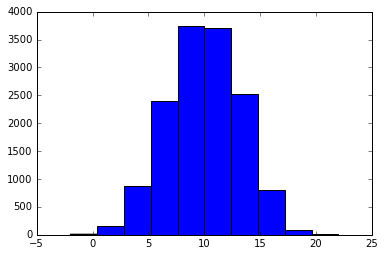

In [113]:
# Combine all text
df['AllText'] = ""
df['primary_kw'].fillna(" ", inplace=True)
df['tags'].fillna(" ", inplace=True)
for i, row in df.iterrows():
    #cv = df.iloc[i,5]+" "+df.iloc[i,6]+" "+df.iloc[i,7]+" "+df.iloc[i,8]+" "+df.iloc[i,9]+" "+df.iloc[i,10]
    #Remove metav and cat
    cv = df.iloc[i,2]+" "+df.iloc[i,5]+" "+df.iloc[i,6]+" "+df.iloc[i,7]+" "+df.iloc[i,9]+" "+df.iloc[i,10]
    df.set_value(i,'AllText',cv)

print df.tail()


# Log to convert to Normal Distribution
df['Log'] = df['freq']*(df['impressions']+1)/1000

for i, row in df.iterrows():
    cv = math.log(df.iloc[i,12],2)
    df.set_value(i,'Log',cv)
    
# analyse data a bit
data_mean = df["Log"].mean()
print data_mean
data_std = df["Log"].std()
print data_std
%matplotlib inline
plt.hist(df["Log"])
plt.show()

# Assign buzzes
df['viral'] = ""
for i, row in df.iterrows():
    if df.iloc[i,12]<=(data_mean-1.5*data_std):
        df.set_value(i,'viral','1buzz')
    elif (df.iloc[i,12]>(data_mean+1.5*data_std)):
        df.set_value(i,'viral','3buzz')
    else:
        df.set_value(i,'viral','2buzz')


#df['viral'] = np.where(df['Log']<data_mean-1*data_std, 'notviral', 'viral')
df['viral_num'] = 0
df['viral_num'] = df.viral.map({'1buzz':1, '2buzz':2, '3buzz':3})

In [114]:
X = df.AllText
y = df.viral_num
# instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_df=0.1)
df.head()

,id,pull_cc,cc,freq,impressions,descr,cat,title,metav,primary_kw,tags,AllText,Log,viral,viral_num
0,4251480,au,en-us,2,29316,Giant man with tiny dog alert!,Celebrity,"The Mountain From ""Game Of Thrones"" Has A Ridi...",buzz,the mountain,dogs game of thrones instagram pomeranians pup...,en-us Giant man with tiny dog alert! Celebrity...,5.873666,2buzz,2
1,4312033,ca,en-us,2,17180,FYI: Ice cream sandwiches &gt; all other sandw...,Food,16 Grown-Up Ice Cream Sandwiches That'll Up Yo...,life,ice cream sandwiches,dessert DIY ice cream food52 homemade ice crea...,en-us FYI: Ice cream sandwiches &gt; all other...,5.102742,1buzz,1
2,4236366,au,en-us,2,3474,"""My mama always said you can tell a lot about ...",Style,17 Shoe Charts Every Guy Needs To Bookmark,life,menslifestyle,charts shoes,"en-us ""My mama always said you can tell a lot ...",2.797013,1buzz,1
3,4306947,in,en-us,2,9027,Let's see if you're a true cheese whiz.,Food,Can You Find All The Cheese?,life,cheese,cheese quiz cheesy Food food quiz jumblequiz t...,en-us Let's see if you're a true cheese whiz. ...,4.174406,1buzz,1
4,4253360,au,en-us,2,7247,The EPA just released first-time guidelines on...,Science,Where To Worry About Fluorinated Chemicals I...,news,science news,epa fluorinated chemicals water,en-us The EPA just released first-time guideli...,3.857583,1buzz,1


In [115]:
df.tail()

,id,pull_cc,cc,freq,impressions,descr,cat,title,metav,primary_kw,tags,AllText,Log,viral,viral_num
14292,4267490,us,en-us,240,16919616,A former Stanford swimmer who sexually assault...,USNews,Here's The Powerful Letter The Stanford Victim...,news,campus sexual assault,stanford university,en-us A former Stanford swimmer who sexually a...,21.953300,3buzz,3
14293,4267490,uk,en-us,242,17616881,A former Stanford swimmer who sexually assault...,USNews,Here's The Powerful Letter The Stanford Victim...,news,campus sexual assault,stanford university,en-us A former Stanford swimmer who sexually a...,22.023534,3buzz,3
14294,4267490,ca,en-us,244,17497742,A former Stanford swimmer who sexually assault...,USNews,Here's The Powerful Letter The Stanford Victim...,news,campus sexual assault,stanford university,en-us A former Stanford swimmer who sexually a...,22.025619,3buzz,3
14295,4209250,au,en-au,274,257463,A definitive ranking of our dirtiest words.,Australia,The 100 Rudest Fucking Things Australians Say,None,Australia,arse over tit arsewipe bloody hell bloody wank...,en-au A definitive ranking of our dirtiest wor...,16.106259,3buzz,3
14296,4206100,in,en-uk,336,1329315,"Don't worry, you won't need to know Chandler B...",UK,"Only A True ""Friends"" Fan Can Get More Than 15...",None,friends,courtney cox david schwimmer Friends quiz frie...,"en-uk Don't worry, you won't need to know Chan...",18.768786,3buzz,3


In [116]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

from sklearn.pipeline import make_pipeline
pipe=make_pipeline(vect, nb)
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
          dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
          lowercase=True, max_df=0.1, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

In [117]:
# calculate accuracy of class predictions
from sklearn.cross_validation import cross_val_score
cross_val_score(pipe,X,y,cv=12,scoring='accuracy').mean()

0.82981844975972141

In [118]:
# import and instantiate a Logistic Regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.pipeline import make_pipeline
pipe=make_pipeline(vect, logreg)
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
          dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
          lowercase=True, max_df=0.1, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('logisticregression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

In [119]:
# calculate accuracy of class predictions
cross_val_score(pipe,X,y,cv=12,scoring='accuracy').mean()

0.87968707842769478

In [120]:
data_mean-1.5*data_std

5.1547876444580458

In [121]:
data_mean+1.5*data_std

14.803347038439068

In [122]:
print data_mean
print data_std

9.97906734145
3.21618646466


In [123]:
df.shape

(14297, 15)

In [124]:
df.viral.value_counts()

2buzz    12382
1buzz     1003
3buzz      912
Name: viral, dtype: int64